In [1]:
from edlut2 import simulation_wrapper as pyedlut
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

In [2]:
simulation = pyedlut.PySimulation_API()

simulation_time = 10.0
simulation_step = 1e-3

In [3]:
# Create the input neuron layers

input_layer = simulation.AddNeuronLayer(
    num_neurons=3,
    model_name='InputSpikeNeuronModel',
    param_dict={},
    log_activity=False,
    output_activity=True)

current_layer = simulation.AddNeuronLayer(
    num_neurons=1,
    model_name='InputCurrentNeuronModel',
    param_dict={},
    log_activity=False,
    output_activity=False
)

In [13]:
simulation.GetAvailableNeuronModels()
simulation.GetNeuronModelInfo('PoissonGeneratorDeviceVector')
# simulation.GetNeuronModelDefParams('PoissonGeneratorDeviceVector')

{'frequency': 'Poisson generator device frequency (Hz): VECTOR',
 'info': 'CPU Poisson generator device able to generate and propagate spike trains to other neuron models'}

In [4]:
# Create the output layer

integration_method = pyedlut.PyModelDescription(model_name='Euler', params_dict={'step': 0.0001})

output_params = {
    'a': 0.02, #0.1,
    'b': 0.25, #0.23,
    'c': -65.0,
    'd': 0.05, #0.2,
    'c_m': 100.0,
    'e_exc': 0.0,
    'e_inh': -63.0,
    'tau_exc': 5.0,
    'tau_inh': 32.0,
    'tau_nmda': 200.0,
    'int_meth': integration_method,
}

output_layer = simulation.AddNeuronLayer(
    num_neurons = 1,
    model_name = 'IzhikevichTimeDrivenModel',
    param_dict = output_params,
    log_activity = False,
    output_activity = True
)

In [5]:
# Create the synapses

sources, targets = [], []
conn_types = []
w_change = []
ws = []
delays = []

# Entrada de corriente
sources.append(current_layer[0])
targets.append(output_layer[0])
conn_types.append(3)
w_change.append(-1)
ws.append(0.0)
delays.append(0.001)

# Entrada de spikes (AMPA, GABA, NMDA)
for i,n in enumerate(input_layer):
    sources.append(n)
    targets.append(output_layer[0])
    conn_types.append(i)
    w_change.append(-1)
    ws.append(2.0)
    delays.append(0.001)

synaptic_params = {
    'weight': ws,
    'max_weight': 1000.0,
    'type': conn_types,
    'delay': delays,
    'wchange': w_change,
    'trigger_wchange': -1
}

_ = simulation.AddSynapticLayer(sources, targets, synaptic_params);

In [6]:
# Initialize the network

simulation.Initialize()

In [7]:
# Inject input spikes and currents to the network

n_spikes = 20
simulation.AddExternalSpikeActivity(
    np.random.rand(n_spikes)*simulation_time, 
    np.random.randint(0,input_layer[-1]+1, size=n_spikes)
)

n_changes = 10
simulation.AddExternalCurrentActivity(
    np.random.rand(n_changes)*simulation_time, 
    current_layer*n_changes, 
    ((np.random.rand(n_changes)-0.5)*2) * 30.0
)

In [8]:
# Run the simulation

state_ptr = simulation.GetLayerState(output_layer) #We obtain a pointer to the state of the layer

states = []
times = []
for i, t in enumerate(np.arange(simulation_step, simulation_time+simulation_step, simulation_step)):
    if (i%1000)==0: state_ptr[0,0] = -80 #With state_ptr being a pointer, we can directly modify EDLUT states from Python!

    simulation.RunSimulation(t)
    states.append(state_ptr.copy()) #We copy and save the state of the layer every timestep (we could do this every N timesteps)
    times.append(t)
    
# Retrieve spikes
st, si = simulation.GetSpikeActivity()
st = np.array(st)
si = np.array(si)

# Retrieve states and times
s = np.array(states).reshape((-1,6))
t = np.array(times)

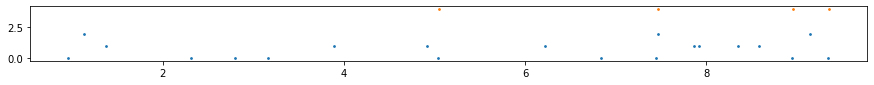

In [9]:
# Plot input and output spikes

plt.rcParams['figure.figsize'] = (15,1)

sub = np.in1d(si, input_layer)
plt.scatter(st[sub], si[sub], s=3)

sub = np.in1d(si, output_layer)
plt.scatter(st[sub], si[sub], s=3)

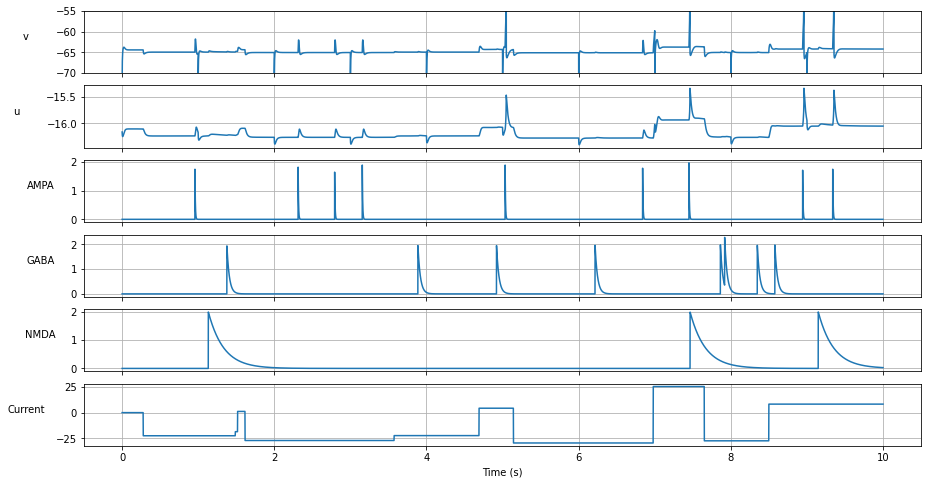

In [10]:
# Plot state variables

variable_names = ['v', 'u', 'AMPA', 'GABA', 'NMDA', 'Current']

plt.rcParams['figure.figsize'] = (15,8)
fig, axs = plt.subplots(6,1, sharex=True)

for i,ax in enumerate(axs):
    ax.plot(t, s[:,i])
    ax.set_ylabel(variable_names[i], rotation=0, labelpad=30)
    ax.grid()
    if i==0: ax.set_ylim((-70,-55))

_ = axs[-1].set_xlabel('Time (s)')